In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import scipy.signal as sig

The goal of this ntoebook is to document, test, and demonstrate advanced methods of estimating the time delay between two signals in the presence of noise and other disturbances. This document begins with a simple correlation function and demonstrates its performance in the presence of a range of disturbances to the underlying signal.

In [2]:
# an Algorithm for creating pink noise
# From Allen Downey's notes here:
# https://www.dsprelated.com/showarticle/908.php
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

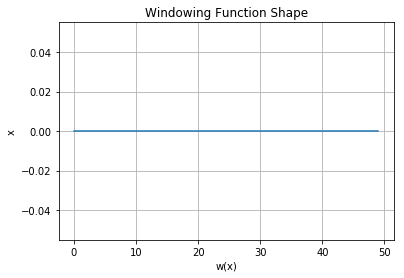

In [3]:
def windowFun(xs):
    l = len(xs)
    # maybe define this a-priori to increase run-speed
    w = sig.windows.hann(l)
    a = np.dot(xs,w)/sum(w)
    return (xs-a) * w

#def windowFun(xs):
#    l = len(xs)
#    return xs * sig.windows.hamming(l)

if 1:
    plt.plot(windowFun(np.ones(50)))
    plt.title('Windowing Function Shape')
    plt.xlabel('w(x)')
    plt.ylabel('x')
    plt.grid()

## Make the signal and test it

In [4]:
samplingRate = 10   # hz
dT = 1/samplingRate # sec
tf = 150
n = tf/dT+1

ts = np.arange(start=0,stop=tf,step=dT)

dt = 300 # We are setting the time delay to be 300 steps
l = 1000
start = 0

# Create the simulated data sets for the sensor signals
u = voss(len(ts))
v = voss(len(ts))
S1 = u[ (start+dt) : (start+dt+l) ]
S2 = u[ start:(start+l) ]
t = ts[ :l]

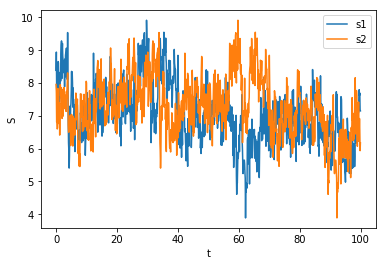

In [5]:
plt.plot(t,S1)
plt.xlabel('t')
#plt.ylabel('S1')
plt.plot(t,S2)
plt.xlabel('t')
plt.ylabel('S')
plt.legend(['s1','s2'])
plt.show()

In [6]:
# compute means and center the data
S1m = sum(S1)/len(S1)
S2m = sum(S2)/len(S2)
print(S1m)
print(S2m)
s1 = S1-S1m
#s1t = S1t-S1m
s2 = S2-S2m

7.050751665458089
7.296255927473512


Correlation and convolution functions both struggle with edge effects (as famously deomnstrated with fourier transform windowing issues). One way to solve this problem is to amke a windowing function that makes the signal appear to periodically repeat in the sampling window.

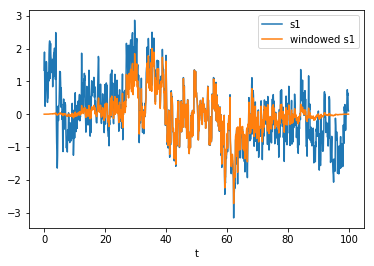

In [7]:
# plot s1 and it's windowed version side-by-side
plt.plot(t,s1)
plt.plot(t,windowFun(s1))
plt.legend(['s1','windowed s1'])
plt.xlabel('t')
plt.show()

### A quick correlation scatter plot shows that, due to the time-shift, there is no correlation between the signals 

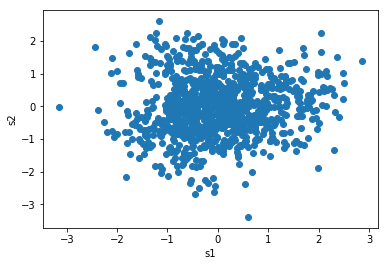

In [8]:
plt.scatter(s1,s2)
plt.xlabel('s1')
plt.ylabel('s2')
plt.show()

Let's look at the variance of the two signals to get an idea of how big the noise is:

In [9]:
s1v = np.var(s1)
s2v = np.var(s2)
print(s1v)
print(s2v)

0.840277408858797
0.8056105889227906


As a reminder of what covariance is: 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Covariance_trends.svg/340px-Covariance_trends.svg.png)

Compute the covariance between x and y

In [10]:
covar = np.cov([s1,s2])[1,0]
print(covar)

0.06779056053077977


Compute the correlation between x and y

In [11]:
corr = covar/np.sqrt(s1v*s2v)
print(corr)

0.08239394517382945


In [12]:
# compute the correlated lag between x and y
# xLag is currently expressed in number of time steps
def corrLag(s1,s2,xLag,show=False,window=False):
    n = len(s1)
    if window:
        s = np.dot( windowFun( s2[int(xLag):]   ),
                    windowFun( s1[:int(n-xLag)] ) )    
    else: 
        s = np.dot(s2[int(xLag):],s1[:int(n-xLag)])
    #s = 0
    #for i in range(n-xLag):
    #    s += x[i+xLag]*y[i]
    cov = np.cov([s1,s2])[0,1]
    
    if show:
        plt.scatter(s2[xLag:],s1[:(n-xLag)])
        plt.xlabel('s2')
        plt.ylabel('s1')
    
    # this equation is taken from the 2.131 notes
    return s/cov/(n-xLag)

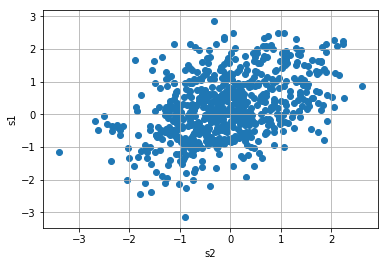

In [13]:
corrLag(s1,s2,320,show=True)
plt.grid(True)

In [14]:
def corrSweep(x,y,lags,show=False,window=False):
    crossCorr = np.zeros(len(lags))
    for i,lag in enumerate(lags):
        crossCorr[i] = corrLag(x,y,lag,window=window)
    
    if show:
        sign = np.sign( crossCorr[np.argmax(abs(crossCorr))] )
        plt.plot( lags,crossCorr/max(abs(crossCorr))*sign ) 
        plt.xlabel('lag')
        plt.ylabel('Cross-correlation')
        plt.grid(True)
    
    return crossCorr, abs(crossCorr).argmax()

In [15]:
# using built-in signal processing tools from python to compute
# the correlation
def fastCorr(s1,s2,show=False):
    FF = sig.correlate(tuple(s2),tuple(s1))
    l = len(s1)
    # assume that we know what direction the time lag will be in
    ff = FF[l:]
    lags = range(0,int(l)-1)
    if show:
        plt.plot(lags,ff/max(ff))
        plt.grid(True)
    return abs(ff).argmax()

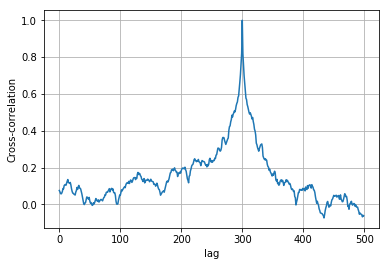

In [16]:
lags = np.arange(0,500)
_, s = corrSweep(s1,s2,lags,True)

The real lag of the data is:

In [17]:
print(s)

300


Which can be clearly seen in this plot:

13.285638955321685

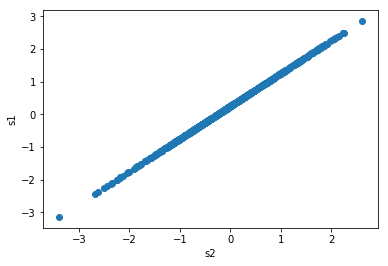

In [18]:
corrLag(s1,s2,300,True)

Now, let's see what effect random noise has on this technique:

In [19]:
e = np.random.rand(len(s2)) + voss(len(s2))
#e = voss(len(y)) add error as pink noise
s2e = s2+2*e

s2em = sum(s2e)/len(s2e)
s2e = s2e-s2em
print(s2em)

16.583237663294792


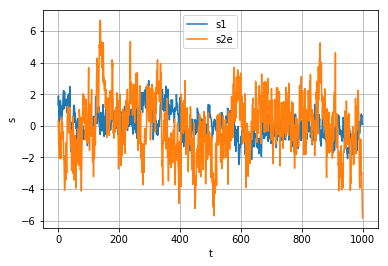

In [20]:
plt.plot(s1)
#plt.plot(y)
plt.xlabel('t')
plt.ylabel('s')
plt.plot(s2e)
plt.xlabel('t')
plt.legend(['s1','s2e'])
plt.grid(True)
plt.show()

300


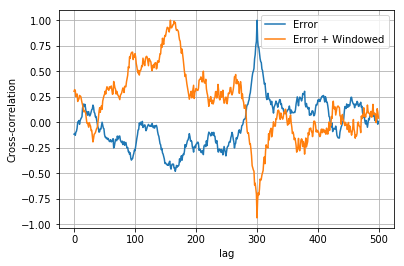

158


In [21]:
s2ew = windowFun(s2e)
s1w = windowFun(s1)

_,E = corrSweep(s1,s2e,lags,show=True)
print(E)

_,EW = corrSweep(s1,s2e,lags,show=True,window=True)
plt.title('')
plt.legend(['Error','Error + Windowed'])
plt.show()
print(EW)

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


299

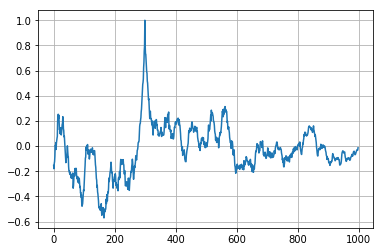

In [22]:
fastCorr(s1,s2e,show=True)

Now, let's see what effect that diffusion (a good proxy for turbulent mixing) has on this:

In [23]:
# x = data set
# dx = spatial length
# k = diffusion coefficient
# n = number of time steps
# t = total time duration of process
def diffuse(x,k,nt,t):
    dx = 0.01
    dt = t/(nt-1)
    nx = len(x)
    main = np.zeros(nx)
    lower = np.zeros(nx-1)
    upper = np.zeros(nx-1)
    
    K = k*dt/dx**2
    
    main[:] = 1+2*K
    lower[:] = -K
    upper[:] = -K
    # add boundary conditions
    main[0] = 1+K
    main[-1] = 1+K
    
    A = sp.sparse.diags( diagonals=[main,lower,upper],
                           offsets=[0,-1,1], shape=(nx,nx),
                           format='csr')
    
    for n in range(0,nt):
        x = sp.sparse.linalg.spsolve(A,x)
    
    return x

### Diffusing the first signal by 1 second, and the second signal by 2 seconds to account for mixing between the two points

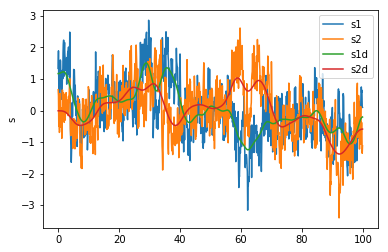

In [24]:
s1d = diffuse(s1,0.01,10,1)
plt.plot(t,s1)
plt.ylabel('s')
s2d = diffuse(s2,.01,20,2)
plt.plot(t,s2)
plt.plot(t,s1d)
plt.plot(t,s2d)
plt.legend(['s1','s2','s1d','s2d'])
plt.show()

### Comparing the performance of lag detection for the normal and unwindowed signal. 
There does not appear to be a major difference in performance

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


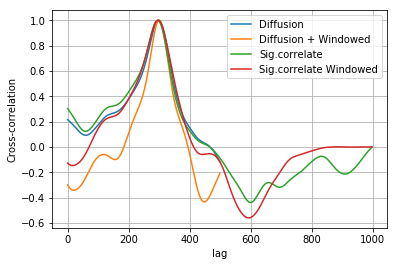

298
300
295
297


In [25]:
s1d = s1d-sum(s1d)/len(s1d)
s2d = s2d-sum(s2d)/len(s2d)

s1dw = windowFun(s1d)
#s2dw = windowFun(s2d)

_,D = corrSweep(s1d,s2d,lags,True)

_,DW = corrSweep(s1d,s2d,lags,True,window=True)
x1 = fastCorr(s1d,s2d,show=True)
x2 = fastCorr(s1dw,s2d,show=True)

plt.title('')
plt.legend(['Diffusion','Diffusion + Windowed',
            'Sig.correlate','Sig.correlate Windowed'])
plt.show()

print(D)
print(DW)
print(x1)
print(x2)


## Now to add error before diffusing

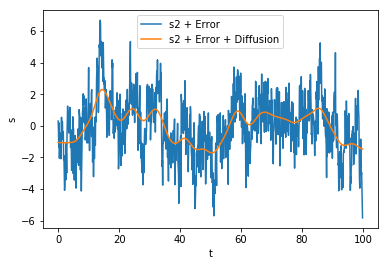

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


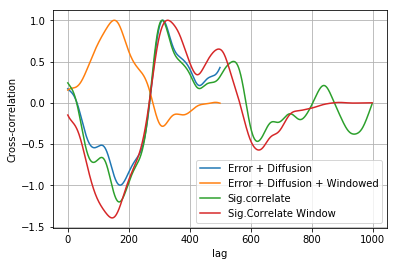

312
153
168
145


In [26]:
s2ed = diffuse(s2e,0.01,20,2)
plt.plot(t,s2e)
plt.plot(t,s2ed)
plt.xlabel('t')
plt.ylabel('s')
plt.legend(['s2 + Error','s2 + Error + Diffusion'])
plt.show()

#s2edw = windowFun(s2ed)
s1dw = windowFun(s1d)

_,ED = corrSweep(s1d,s2ed,lags,True)

_,EDW = corrSweep(s1d,s2ed,lags,show=True,window=True)

x1 = fastCorr(s1d,s2ed,show=True)
x2 = fastCorr(s1dw,s2ed,show=True)

plt.title('')
plt.legend(['Error + Diffusion','Error + Diffusion + Windowed',
           'Sig.correlate','Sig.Correlate Window'],loc='lower right')
plt.show()

print(ED)
print(EDW)
print(x1)
print(x2)

## Now with error after diffusing

In [27]:
import time

-0.04584240913391113
-0.002001523971557617


C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


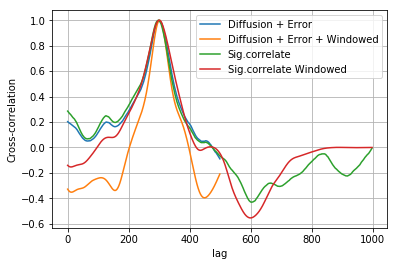

300
301
297
300


In [28]:
s2de = diffuse(s2,0.01,20,2)+e/4
s2de = s2de-sum(s2de)/len(s2de)

if 0:
    plt.plot(t,s2e)
    plt.plot(t,s2de)
    plt.show()

#xd = xd-sum(xd)/len(xd)
#s2dew = windowFun(s2de)

startTime = time.time()
_,DE  = corrSweep(s1d,s2de,lags,show=True)
print(startTime-time.time())
_,DEW = corrSweep(s1d,s2de,lags,show=True,window=True)

startTime = time.time()
x1 = fastCorr(s1d,s2de,show=True)
print(startTime-time.time())
x2 = fastCorr(s1dw,s2de,show=True)

plt.legend(['Diffusion + Error','Diffusion + Error + Windowed',
           'Sig.correlate','Sig.correlate Windowed'])
plt.show()

print(DE)
print(DEW)
print(x1)
print(x2)

### Let's see what happens when one of the sensors is not properly calibrated compared to the other sensor

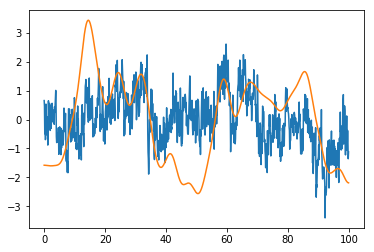

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


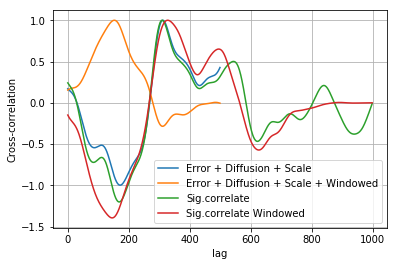

312
153
168
145


In [29]:
s2eds = diffuse(s2e,0.01,20,2)*1.5
s2eds = s2eds-sum(s2eds)/len(s2eds)

s2edsw = windowFun(s2eds)
#s2edsw = s2edsw-sum(s2edsw)/len(s2edsw)

plt.plot(t,s2)
plt.plot(t,s2eds)
plt.show()

_,EDS  = corrSweep(s1d,s2eds,lags,show=True)
_,EDSW = corrSweep(s1d,s2eds,lags,show=True,window=True)
x1 = fastCorr(s1d,s2eds,show=True)
x2 = fastCorr(s1dw,s2eds,show=True)
plt.legend(['Error + Diffusion + Scale','Error + Diffusion + Scale + Windowed',
           'Sig.correlate','Sig.correlate Windowed'])
plt.show()

print(EDS)
print(EDSW)
print(x1)
print(x2)